In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd 
from torch.utils.data import DataLoader ,Dataset
import numpy as np 
import matplotlib.pyplot as plt
from torch.autograd import Variable
import torch.optim as optim






In [275]:
X=pd.read_csv("/Users/stef_cm/Desktop/Clean_data1.csv" , sep=",")

FileNotFoundError: [Errno 2] No such file or directory: '/Users/stef_cm/Desktop/Clean_data1.csv'

In [270]:
# Load your data
#X = pd.read_csv("../Data/Clean.csv", sep=",") # This should be the matrix of microbiome data
#X= pd.DataFrame(X)
y = X[["Sample", "Case"]] # This should be the binary variable indicating healthy/diseased
X.drop(X[["Sample", "Case"]], axis=1, inplace=True)
X = X.applymap(lambda x: 1 if x == 'Healthy' else x)






In [271]:
# Extract the feature columns and label column
features = X.values
label = y['Case']


# Convert each element of the array to a float
features = features.astype(float)

# Convert the labels to numerical values
label_dict = {'Healthy': 1, 'Diseased': 0}
label_n = [label_dict[label] for label in label]

# Convert the feature columns to a PyTorch tensor
features_tensor = torch.tensor(features)

# Convert the label column to a PyTorch tensor
label_tensor = torch.tensor(label_n)

# Create a TensorDataset from the feature and label tensors
dataset = torch.utils.data.TensorDataset(features_tensor, label_tensor)

#Save it to tensor .pt objects
torch.save(label_tensor, '../Data/labels.pt')
torch.save(features_tensor, '../Data/features.pt')



KeyError: nan

In [120]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, z_dim):
        super(VAE, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.z_dim = z_dim
        
        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, z_dim)
        self.fc22 = nn.Linear(hidden_dim, z_dim)
        
        # Decoder
        self.fc3 = nn.Linear(z_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)
        
    def encode(self, x):
        h1 = nn.functional.relu(self.fc1(x))
        mu, logvar = self.fc21(h1), self.fc22(h1)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    
    def decode(self, z):
        h3 = nn.functional.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))
    
    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, self.double().input_dim).double())
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [178]:
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 725), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [97]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [117]:
def train_vae1(model, eex, epochs, batch_size, learning_rate):
    train_loader =  DataLoader(dataset, batch_size=20, shuffle=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        
        for batch_idx, eex in enumerate(train_loader):
           
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss = loss_function(recon_batch, data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
            
        print('Epoch: {} \t Loss: {:.6f}'.format(epoch+1, train_loss / len(train_loader.dataset)))

In [250]:
input_dim = 725 # Define the size of your input data
my_list = 150
z_dim = 2 # Define the size of the latent space
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VAE(input_dim,my_list, z_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
num_epochs = 50

In [251]:
# Load the microbiome data and labels into PyTorch tensors
data = torch.load("../Data/features.pt")
labels = torch.load("../Data/labels.pt")
dataset = torch.utils.data.TensorDataset(data, labels)
# Define the dataset and dataloader
dataloader = DataLoader(dataset, batch_size=12)

In [253]:
train_vae1(model, dataloader, 100, 16, 1e-4)

Epoch: 1 	 Loss: 764.666317
Epoch: 2 	 Loss: 625.709599
Epoch: 3 	 Loss: 573.389646
Epoch: 4 	 Loss: 537.390690
Epoch: 5 	 Loss: 511.327963
Epoch: 6 	 Loss: 491.561678
Epoch: 7 	 Loss: 477.248808
Epoch: 8 	 Loss: 462.937206
Epoch: 9 	 Loss: 453.064215
Epoch: 10 	 Loss: 446.511756
Epoch: 11 	 Loss: 438.570336
Epoch: 12 	 Loss: 432.735143
Epoch: 13 	 Loss: 427.003734
Epoch: 14 	 Loss: 421.426194
Epoch: 15 	 Loss: 418.984598
Epoch: 16 	 Loss: 415.622290
Epoch: 17 	 Loss: 412.559012
Epoch: 18 	 Loss: 410.188855
Epoch: 19 	 Loss: 408.939873
Epoch: 20 	 Loss: 410.894805
Epoch: 21 	 Loss: 400.314226
Epoch: 22 	 Loss: 399.351799
Epoch: 23 	 Loss: 397.281637
Epoch: 24 	 Loss: 403.118111
Epoch: 25 	 Loss: 401.452259
Epoch: 26 	 Loss: 392.291188
Epoch: 27 	 Loss: 398.098880
Epoch: 28 	 Loss: 392.421752
Epoch: 29 	 Loss: 390.466900
Epoch: 30 	 Loss: 391.456172
Epoch: 31 	 Loss: 390.309881
Epoch: 32 	 Loss: 393.264341
Epoch: 33 	 Loss: 392.976805
Epoch: 34 	 Loss: 388.305371
Epoch: 35 	 Loss: 389.0

In [254]:
torch.save(VAE.state_dict(model), '../Model/vae.pth')

In [255]:
#load Model and encode data
VAE.load_state_dict(model, torch.load('vae.pth'))


<All keys matched successfully>

In [256]:
with torch.no_grad():
    z, _ = model.encode(data)

In [257]:
# Import dataset and classes needed in this example:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.inspection import DecisionBoundaryDisplay
from itertools import product

# Import Gaussian Naive Bayes classifier:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score


In [260]:
# Split dataset into random train and test subsets:
train, test, train_labels, test_labels = train_test_split(z, labels, test_size=0.2, random_state=11)

# Initialize classifier:
gnb = GaussianNB()

# Train the classifier:
classifier = gnb.fit(train, train_labels)
# Make predictions with the classifier:
predictive_labels = gnb.predict(test)
print(predictive_labels)

# Evaluate label (subsets) accuracy:
print(accuracy_score(test_labels, predictive_labels))

[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 1
 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0
 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0
 0 0 0 0 1 0 0 1 1 1 0]
0.7295918367346939


In [261]:
z

tensor([[-1.9567,  0.3768],
        [-1.9598,  0.3847],
        [-1.9560,  0.3760],
        ...,
        [-0.7016, -0.8896],
        [-0.7037, -0.8885],
        [-0.7053, -0.8882]], dtype=torch.float64)

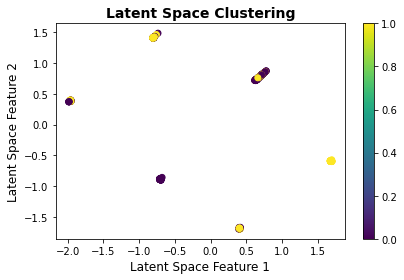

In [262]:
# assume you have X as your latent space data and y as your labels
gnb = GaussianNB()
y_pred = gnb.fit(z, labels).predict(z)

plt.scatter(z[:,0], z[:,1], c=labels)
plt.title('Latent Space Clustering', fontsize=14, fontweight='bold')
plt.xlabel('Latent Space Feature 1', fontsize=12)
plt.ylabel('Latent Space Feature 2', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.colorbar()
plt.tight_layout()
plt.show()


In [263]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

In [264]:
clf = LogisticRegression(random_state=42, max_iter=1000)
clf.fit(z, labels)

LogisticRegression(max_iter=1000, random_state=42)

In [265]:
# Evaluate the classifier on the validation set
y_val_pred = clf.predict(test)
val_accuracy = accuracy_score(test_labels, y_val_pred)
val_confusion_matrix = confusion_matrix(test_labels, y_val_pred)

In [266]:
print(f"Validation accuracy: {val_accuracy:.4f}")
print(f"Validation confusion matrix:\n{val_confusion_matrix}")

Validation accuracy: 0.5867
Validation confusion matrix:
[[71 44]
 [37 44]]


In [267]:
# Plot the decision boundaries and data points
x_min, x_max = test.min() - 0.1, test.max() + 0.1
y_min, y_max = test.min() - 0.1, test.max() + 0.1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))


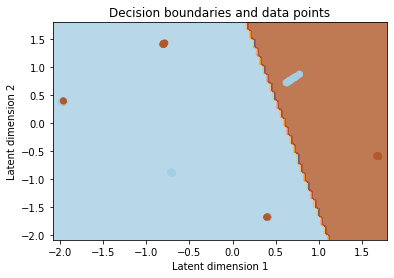

In [268]:
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)
plt.scatter(test[:, 0], test[:, 1], c=test_labels, cmap=plt.cm.Paired)
plt.title('Decision boundaries and data points')
plt.xlabel('Latent dimension 1')
plt.ylabel('Latent dimension 2')
plt.show()